In [21]:
import numpy as np 
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split,GridSearchCV 
from sklearn import linear_model, datasets
from sklearn.metrics import confusion_matrix, classification_report, precision_score

# Data Prepration

In [2]:

root=r"C:\Users\STEVE\Desktop\data\ebook exce\takehome exams"
path=os.path.join(root, 'conversion_data.csv')
df=pd.read_csv(path)
print(df.info())
print(df.columns)
for col in df.columns:
    print("number of unique values in column %s =  %d"%(col,(df[str(col)].nunique())))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB
None
Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')
number of unique values in column country =  4
number of unique values in column age =  60
number of unique values in column new_user =  2
number of unique values in column source =  3
number of unique values in column total_pages_visited =  29
number of unique values in column converted =  2


Conclusion 1) The number of entries is equal to the number of non-null values of each column, so there are no missing data

Conclusion 2) It seems that all the columns except age and total_oages_visisted are categorical data. I plot them to check the values and if the data is unbalanced


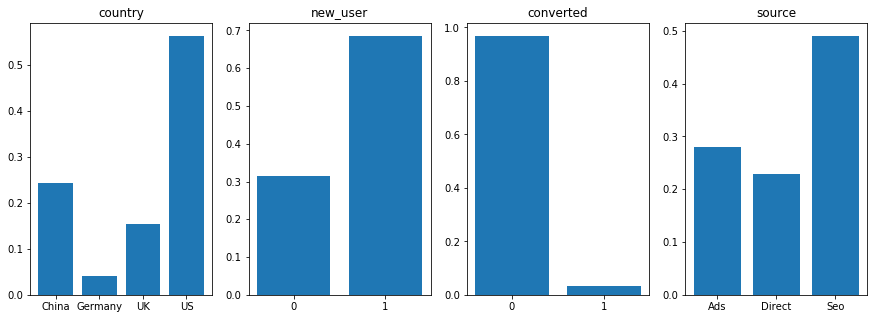

In [3]:
###look at the categirical data and their counts
fig = plt.figure(figsize=(15,5))
col_list=['country', 'new_user', 'converted', 'source']

for pos, col in enumerate(col_list):
    percent_summary=(df.groupby([str(col)]).count()/df[str(col)].count())
    category_num=len(percent_summary.index.tolist())
    a = fig.add_subplot(1, len(col_list), pos+1)
    a.set_title(str(col))
    plt.bar(np.arange(category_num), percent_summary.iloc[:,0])
    plt.xticks(np.arange(category_num),percent_summary.index)
plt.show()

#Conclusion 1: data looks OK and there is no type or non-sense label
#Conclusion 2: Column "converetd" is our data to predict; and it is not balanced
#next, I will check for continueous data to see if there are unreasonable values

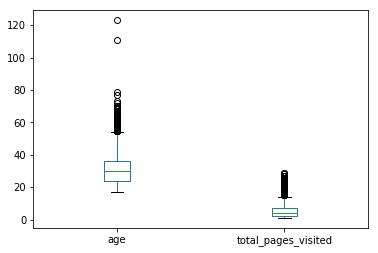

In [4]:
df[['age','total_pages_visited']].plot.box()
plt.show()

###there are two age.values greater than 100. I will remove them and then split data to train and test subset

In [42]:
df=df[df.age<90]
train, test=train_test_split(df, test_size=0.3,  random_state=11, stratify=df.converted)

##I will map the categorical data. this will version will be used for decision tree and random forest 

In [44]:
def map_data(my_df):
    df_=my_df.copy()
    map_country = {'China': 1, 'Germany': 2, 'UK':3, 'US':4}
    map_source = {'Ads': 1, 'Direct': 2, 'Seo':3}
    df_.replace({'country': map_country, 'source': map_source}, inplace=True)
    return df_
train_converted=map_data(train)
test_converted=map_data(test)

,country,age,new_user,source,total_pages_visited,converted
93163,China,23,1,Direct,5,0
94412,US,27,1,Direct,10,0
316053,UK,34,1,Direct,5,0


 since the categorical data is not ordinal, I will create dummy variables to be used in logistic regression 

In [46]:
def create_dummy(df, col_list):
    dummies = pd.get_dummies(df[col_list])
    df_with_dummy=pd.concat((df,dummies),axis=1)
    df_with_dummy.drop(col_list, inplace=True, axis=1)
    return df_with_dummy
train_dummy=create_dummy(train, ['source', 'country'])
test_dummy=create_dummy(test, ['source', 'country'])
test_dummy.head(4)

,age,new_user,total_pages_visited,converted,source_Ads,source_Direct,source_Seo,country_China,country_Germany,country_UK,country_US
93163,23,1,5,0,0,1,0,1,0,0,0
94412,27,1,10,0,0,1,0,0,0,0,1
316053,34,1,5,0,0,1,0,0,0,1,0
221916,46,0,1,0,0,0,1,0,0,1,0


,age,new_user,total_pages_visited,converted,source_Ads,source_Direct,source_Seo,country_China,country_Germany,country_UK,country_US
230591,31,0,2,0,0,0,1,0,0,1,0
228730,32,1,6,0,0,0,1,1,0,0,0
252124,29,1,4,0,0,0,1,0,0,1,0


In [47]:
def plot_ROC(FP, TP):
    TP.append(1)
    FP.append(1)
    fig, ax=plt.subplots(1,1)
    ax.plot(FP,TP)
    ax.plot([0,1],[0,1], 'k--')
    plt.show()
def compute_AUC(FP,TP):
    s=0
    for i in range(0,len(FP)-1):
        width=FP[i+1]-FP[i]
        height=(TP[i+1]+TP[i])/2
        s=s+width*height
    return s
def create_weights():
    Interval1=np.arange(0.1,0.91,0.2)
    Interval2=np.arange(0.91,0.991,0.02)
    Interval3=np.arange(0.991,0.9991,0.002)
    weights=np.concatenate((Interval1,Interval2,Interval3))
    return weights
def determine_best_weight(TP,FP, weights):
    diff=np.asarray(TP)-np.asarray(FP)
    return weights[np.argmax(diff)]
def logit_ROC(X, Y):
    TP,FP=[0],[0]
    weights=create_weights()
    for w in weights:
        logreg = linear_model.LogisticRegression(C=1e5, fit_intercept=True, class_weight={1:w, 0:(1-w)})
        logreg.fit(X, Y)
        pred=logreg.predict(X)
        tn, fp, fn, tp=confusion_matrix(Y, pred).ravel()
        TP.append(tp/(tp+fn))
        FP.append(fp/(fp+tn))
    plot_ROC(FP, TP)
    print('best weight=%f'%determine_best_weight(TP,FP, weights))
    return (FP, TP)

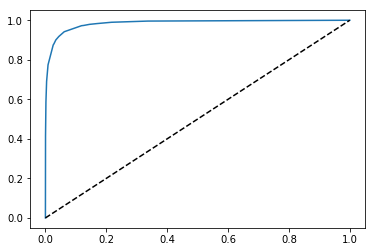

best weight=0.990000
AUC for the training data=0.984454


In [52]:
X_train=train_dummy.loc[:,train_dummy.columns!='converted']
Y_train=train_dummy['converted']
fp,tp=logit_ROC(X_train,Y_train)
print('AUC for the training data=%f'%compute_AUC(fp,tp))

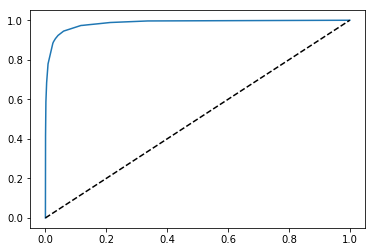

best weight=0.990000
AUC for the test data=0.985210


In [58]:
X_test=test_dummy.iloc[:,test_dummy.columns!='converted']
Y_test=test_dummy['converted']
fp,tp=logit_ROC(X_test,Y_test)
print('AUC for the test data=%f'%compute_AUC(fp,tp))

#the AUC for test and train data are close. the best weights are equal for both test and training data, which is good

# ####beginning of random forest####



In [9]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import pydot
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz

In [10]:
X=train[['country', 'new_user','age','total_pages_visited', 'source']]
Y=train['converted'] 
xtest=test[['country', 'new_user','age','total_pages_visited', 'source']]
ytest=test['converted'] 

In [14]:
clf = RandomForestClassifier(n_estimators=100, max_features='sqrt',max_depth=3, random_state=11, oob_score=True)
clf=clf.fit(X, Y)

In [15]:
importance=pd.DataFrame({'imp':clf.feature_importances_*1000}, index=X.columns)
importance

,imp
country,59.261576
new_user,97.571069
age,23.682419
total_pages_visited,819.367359
source,0.117577


In [16]:

print ("error=", 1-clf.oob_score_)
print(1-clf.score(xtest, ytest))

error= 0.01530861516747195
0.014577197926892382


In [17]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

In [18]:
params = {'n_estimators': 100, 'max_depth': 3, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
clf = GradientBoostingClassifier(**params)
clf.fit(X, Y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=3, subsample=0.5, verbose=0,
              warm_start=False)

In [19]:
print(clf.feature_importances_)
print(X.columns)


[0.04280038 0.0387041  0.00840744 0.91008808 0.        ]
Index(['country', 'new_user', 'age', 'total_pages_visited', 'source'], dtype='object')


In [24]:
#pdp, axes = partial_dependence(clf,[0,1],X=X, grid_resolution=50)

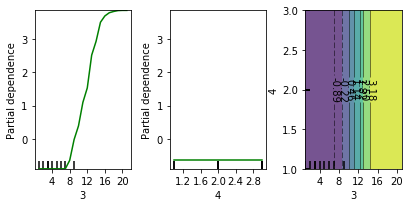

In [35]:
features = [ 3,4, (3, 4)]
fig, axs = plot_partial_dependence(clf, X, features, label=1)
plt.show()

In [11]:
clf1 = DecisionTreeClassifier(max_depth=3)
clf1 = clf1.fit(X, Y)

In [12]:
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return(graph)

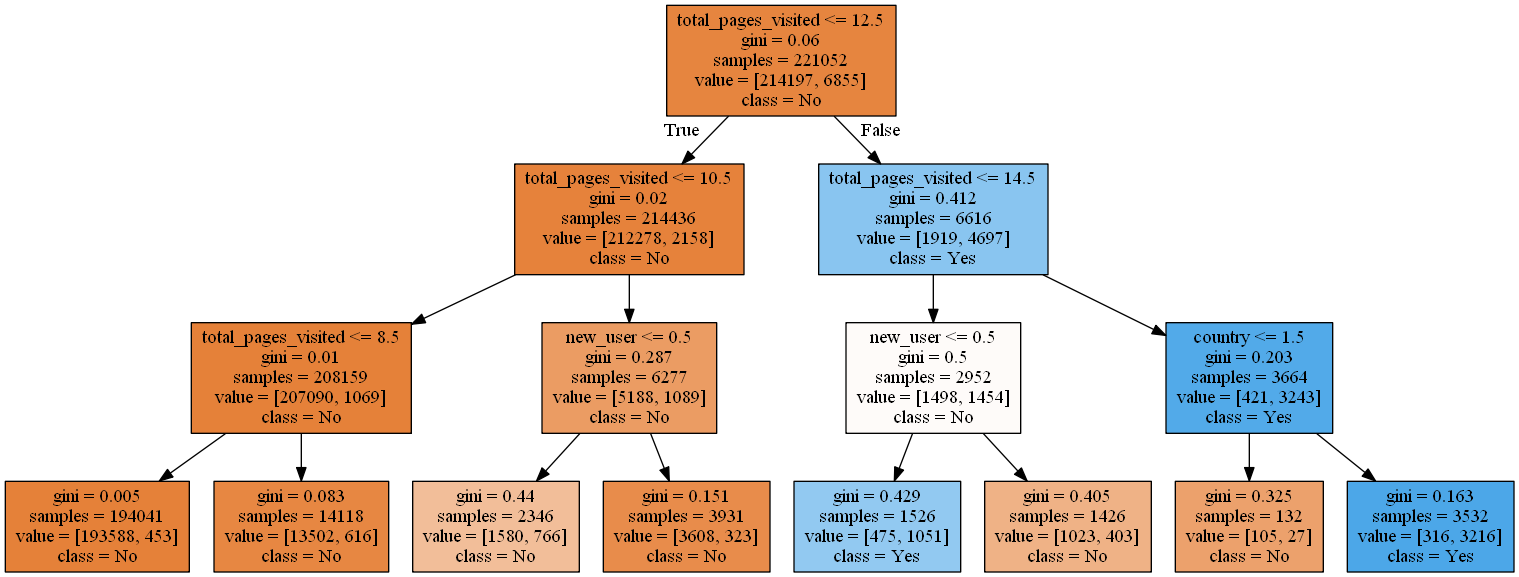

In [13]:
graph3, = print_tree(clf1, features=X.columns, class_names=['No', 'Yes'])
Image(graph3.create_png())

In [ ]:
print(clf1.feature_importances_)
print(clf1.tree_)

In [41]:
from sklearn import metrics
true_labels=Y
pred=clf1.predict_proba(X)[:,0]

fpr, tpr, thresholds = metrics.roc_curve(Y, pred, pos_label=0)

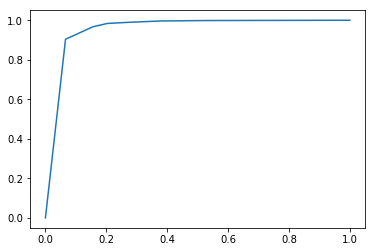

In [42]:
fig, ax=plt.subplots(1,1)
ax.plot(fpr,tpr)
plt.show()